## Оценка эмоциональности текста 

Задача заключается в определении того, насколько положительным или негативным является текст в твите. 

Датасет текста. Включает в себя набор твитов разной эмоциональной окраски, а также информацию о твите. 

http://help.sentiment140.com/for-students/ 

Данные представляют собой CSV-файл с удаленными смайликами. Формат файла данных имеет 6 полей:

0 - **polarity** -  полярность твита (0 = отрицательный, 2 = нейтральный, 4 = положительный)

1 - **id** твита (2087)

2 - **date_time** (сб 16 мая 23:58:44 UTC 2009)

3 - **query**  - Запрос. Если запроса нет, то это значение NO_QUERY.

4 - **user_name** - пользователь, который написал твит (robotickilldozr)

5 - **tweet_text** 

Эти библиотеки необходимо установить.
```
!pip install spacy

!python -m spacy download en_core_web_lg
```

In [19]:
# !wget 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip' -O data.zip

# import zipfile # Библиотека для работы с zip архивами
# import os      # Библиотека для работы с фаловой системой 

# # Прописываем путь к файлу с архивом
# zip_file = 'data.zip'

# # Распаковываем архив
# z = zipfile.ZipFile(zip_file, 'r')
# z.extractall()

# # Просмотр результата разархивации
# print(os.listdir())

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics import roc_auc_score
from sklearn import decomposition, ensemble
import nltk

from nltk.corpus import stopwords
from tqdm import tqdm

import re
import spacy
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

import warnings
warnings.filterwarnings('ignore')

from utils import apostrophe_dict, emoticon_dict, short_word_dict  # см. файл utils.py

# !pip install spacy
# !python -m spacy download en_core_web_lg

In [3]:
tqdm.pandas()

In [13]:
# Файл не содержит заголовков для столбцов, поэтому установим их самостоятельно.
df_collumns = ['polarity','id','date_time','query','user_name','tweet']

In [25]:
train_df = pd.read_csv('training.1600000.processed.noemoticon.csv',header=None, names=df_collumns ,encoding = "ISO-8859-1")

In [26]:
train_df.head(3)

,polarity,id,date_time,query,user_name,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [27]:
train_df.columns

Index(['polarity', 'id', 'date_time', 'query', 'user_name', 'tweet'], dtype='object')

Для решения нашей задачи нам необходимы только столбцы `polarity` и `text`. остальные столбцы мы удалим.


In [28]:
train_df = train_df[["polarity","tweet"]]

train_df.head()

,polarity,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [29]:
# По итогу у нас только два класса. негативные и положительные комментарии. 

train_df['polarity'].value_counts()  

0    800000
4    800000
Name: polarity, dtype: int64

In [30]:
# Приведем данные стобца 'polarity' к двоичному виду. 

train_df['polarity'] = np.where(train_df['polarity']==4,1,0)

In [31]:
train_df.iloc[0].tweet

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

#### Предобработка текста

Сделаем некоторую базовую предобработку текста: 
- уберем апострофы
- уберем специальные символы
- приведем к нижнему регистру
- сделаем токенизацию
- уберем стоп-слова 
- сделаем лемматизацию

In [33]:
# Теперь повторим это для всех записей.
def replase_words(text,dict_): 
    output = ''
    for word in text.split(' '):
        word = word.strip()
        if word in dict_.keys(): 
            output += ' ' + dict_[word]
        else:
            output += ' ' + word
    return output

In [34]:
def clean_text(text):
    #  Удалим @user из всех твитов с помощью паттерна "@[\w]*".
    text = re.sub("@[\w]*","",text)
    # train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub("http[\w]*","",x))
    # Заменим эмодзи на соответствующие им слова.
    text = replase_words(text, emoticon_dict)
    # Переведем все записи в нижний регистр. 
    text = text.lower()
    # Заменим сокращения на их полные формы
    text = replase_words(text, apostrophe_dict)
    text = replase_words(text, short_word_dict)
    # Переведем все записи в нижний регистр. 
    text = text.lower()
    # Заменим пунктуацию на пробелы.
    text = re.sub("[^\w\s]"," ",text)
    # Заменим спецсимволы на пробелы.
    text = re.sub("[^a-zA-Z\_]"," ",text)
    # Удалим из текста слова длиной в 1 символ. За исключением "I" наверное он должен играть какуюто роль.
    text = ' '.join([w for w in text.split() if len(w)>1 and w != "i"])
    return text

In [35]:
train_df['tweet'] = train_df['tweet'].progress_apply(lambda x: clean_text(x))

100%|██████████| 1600000/1600000 [00:55<00:00, 28603.10it/s]


In [38]:
train_df.head(5)

,polarity,tweet
0,0,http twitpic com zl awww that_has that_is bumm...
1,0,is upset that he cannot update his facebook by...
2,0,dived many times for the ball managed to save ...
3,0,my whole body feels itchy and like its on fire
4,0,no it_has it_is not behaving at all i_am mad w...


In [39]:
train_df.iloc[0].tweet

'http twitpic com zl awww that_has that_is bummer you shoulda got david carr of third day to do it'

In [37]:
nlp = spacy.load("en_core_web_lg", disable=["ner"])

def lemmatize_text(text):
    doc = nlp(text)
    tokens=[token.lemma_.strip() for token in doc 
             if (not token.is_stop) or token.lemma_ in ['no','not']
            ]
    text=" ".join(tokens)
    return tokens

In [39]:
# Лемматизация текста. 
train_df['tweet'] = train_df['tweet'].progress_apply(lambda x: lemmatize_text(x))

100%|██████████| 1600000/1600000 [3:38:16<00:00, 122.17it/s]


In [40]:
print(train_df.iloc[4].tweet)

['no', 'it_has', 'it_is', 'not', 'behave', 'i_am', 'mad', 'not']


Очистка текста завершена. Сохраним результаты, чтобы при тюнинге модели не пришлось выполнять ее повторно.

In [110]:
train_df.to_csv('train_preposed.csv')

## Построение моделей
  
Загрузим датасет с очищенными данными.

In [10]:
train_df = pd.read_csv('train_preposed.csv')
train_df.head(3)

,Unnamed: 0,polarity,tweet
0,0,0,"['http', 'twitpic', 'com', 'zl', 'awww', 'that..."
1,1,0,"['upset', 'not', 'update', 'facebook', 'texte'..."
2,2,0,"['dive', 'time', 'ball', 'manage', 'save', 're..."


In [11]:
train_df = train_df[['polarity','tweet']]
train_df.head(2)

,polarity,tweet
0,0,"['http', 'twitpic', 'com', 'zl', 'awww', 'that..."
1,0,"['upset', 'not', 'update', 'facebook', 'texte'..."


Видимо, при последнем сохранении я передал массив, вместо строк. Поэтому, преде тем как приступить к обучению модели необходимо убрать все лишние символы.

In [12]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: re.sub("[^\w\s]","",x))
train_df.head(2)

,polarity,tweet
0,0,http twitpic com zl awww that_has that_is bumm...
1,0,upset not update facebook texte cry result sch...


In [13]:
train_df['tweet'].isna().value_counts()

False    1600000
Name: tweet, dtype: int64

In [14]:
train_df['polarity'].value_counts()

0    800000
1    800000
Name: polarity, dtype: int64

Разделим выборку на обучающую, тестовую и валидационную.

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df['tweet'],
                                                                    train_df['polarity'],
                                                                    test_size=0.4, 
                                                                    random_state=35, 
                                                                    shuffle=True,
                                                                    stratify=train_df['polarity']
                                                                    )

X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test,
                                                                y_test,
                                                                test_size=0.5, 
                                                                random_state=35, 
                                                                shuffle=True,
                                                                stratify=y_test
                                                                )

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_val = encoder.fit_transform(y_val)

In [8]:
print(len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val))

960000 960000 320000 320000 320000 320000


In [9]:
# ngram level tf-idf 
tfidf_vect = TfidfVectorizer(analyzer='word', 
                                   token_pattern=r'\w{1,}', 
                                #  ngram_range=(2,3), 
                                   max_features=20000
                                   )
                                   
tfidf_vect.fit(train_df['tweet'])

TfidfVectorizer(max_features=20000, token_pattern='\\w{1,}')

In [10]:
print(len(tfidf_vect.get_feature_names()))

20000


In [11]:
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)
xval_tfidf =  tfidf_vect.transform(X_val)

In [12]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    # print('ROC_AUC',metrics.roc_auc_score(predictions, y_val))
    
    return metrics.accuracy_score(predictions, y_val)

Опробуем несколько вариантов моделей машинного обучения.

т.к. выборка сбаланисровнна, для проверки качества модели можно использовать метрику accuracy.

# LogReg

In [13]:
# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(),
                       xtrain_tfidf,
                       y_train,
                       xval_tfidf
                     )
print("Accuracy: ", accuracy)

Accuracy:  0.781953125


# XGBoost

In [14]:
import xgboost

In [15]:
accuracy = train_model(xgboost.XGBClassifier(), 
                       xtrain_tfidf.tocsc(), 
                       y_train, 
                       xval_tfidf.tocsc()
                       )
print("Accuracy: ", accuracy)

[18:33:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.75150625


# RNN

In [16]:
import pickle
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, GRU, Conv1D
from tensorflow.keras.layers import InputLayer, Dropout, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping 

In [17]:
data_labels = ['negative', 'positive']

In [18]:
embed_size = 50             # how big is each word vector
max_features = 10000        # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200                # max number of words in a comment to use
num_classes = 2
embedding_dim=200

In [19]:
tokenizer = Tokenizer(num_words=max_features, split=' ',)
tokenizer.fit_on_texts(list(train_df['tweet']))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)

In [20]:
word_count = len(tokenizer.index_word)+1

In [21]:
training_length = max([len(i.split()) for i in X_train])

In [22]:
X_train = pad_sequences(list_tokenized_train, maxlen=training_length)
X_test = pad_sequences(list_tokenized_test, maxlen=training_length)
X_val = pad_sequences(list_tokenized_val, maxlen=training_length)

In [23]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [24]:
embedding = Embedding(
                input_dim = word_count,
                input_length = training_length,
                output_dim = embedding_dim,
                # trainable = True,
                mask_zero = True
                )

In [25]:
model = Sequential()

model.add(embedding)
model.add(Bidirectional(LSTM(300)))

# model.add(GlobalAveragePooling1D())
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 57, 200)           55851200  
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1202400   
_________________________________________________________________
dense (Dense)                (None, 256)               153856    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 57,207,970
Trainable params: 57,207,970
Non-trainable params: 0
_________________________________________________________________


In [26]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [27]:
# Параметры компилляции
model.compile(loss='categorical_crossentropy',# 'binary_crossentropy'
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
history = model.fit(X_train,y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    batch_size=1000,
                    verbose=1
                   )

Epoch 1/10
960/960 [==============================] - 1281s 1s/step - loss: 0.4596 - accuracy: 0.7825 - val_loss: 0.4396 - val_accuracy: 0.7944
Epoch 2/10
960/960 [==============================] - 1322s 1s/step - loss: 0.4251 - accuracy: 0.8030 - val_loss: 0.4360 - val_accuracy: 0.7981
Epoch 3/10
960/960 [==============================] - 1318s 1s/step - loss: 0.4092 - accuracy: 0.8114 - val_loss: 0.4359 - val_accuracy: 0.7986
Epoch 4/10
960/960 [==============================] - 1320s 1s/step - loss: 0.3934 - accuracy: 0.8201 - val_loss: 0.4430 - val_accuracy: 0.7978
Epoch 5/10
960/960 [==============================] - 1321s 1s/step - loss: 0.3756 - accuracy: 0.8288 - val_loss: 0.4550 - val_accuracy: 0.7954
Epoch 6/10
960/960 [==============================] - 1337s 1s/step - loss: 0.3543 - accuracy: 0.8391 - val_loss: 0.4768 - val_accuracy: 0.7923
Epoch 7/10
960/960 [==============================] - 1293s 1s/step - loss: 0.3303 - accuracy: 0.8505 - val_loss: 0.5209 - val_accuracy:

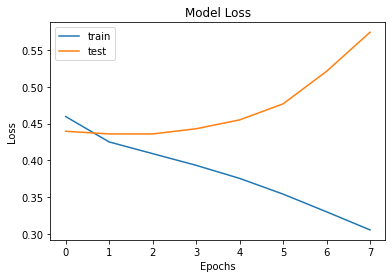

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

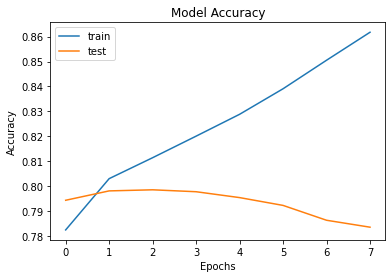

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [31]:
model.save_weights('sentiment_pred.h5')

In [32]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

In [33]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print()
    print(pd.crosstab(y_test_true, y_test_pred))

In [34]:
# Декодируем полученные значения. 
y_train_pred = np.argmax(model.predict(X_train, batch_size=64,),axis=1)
y_test_pred = np.argmax(model.predict(X_val,batch_size=64),axis=1)
y_train_1 = np.argmax(y_train, axis=1)
y_test_1 = np.argmax(y_val, axis=1)

get_classification_report(y_train_1, y_train_pred, y_test_1, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.82      0.83    480000
           1       0.82      0.83      0.83    480000

    accuracy                           0.83    960000
   macro avg       0.83      0.83      0.83    960000
weighted avg       0.83      0.83      0.83    960000

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    160000
           1       0.80      0.80      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

CONFUSION MATRIX


col_0       0       1
row_0                
0      127131   32869
1       31852  128148


К сожалению, это максимальное качество, которго удалось добиться на данном датасете.
Как видно, в данном варианте нейронная сеть не дает никаких преимуществ перед классическими методами ML.
 Качество практически одинаковое, при том что для LogReg  и XGBoost я даже не выполнял подбор параметров! 